In [1]:
### Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
import re
from matplotlib.gridspec import GridSpec
import seaborn as sb
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## The Aim in this notebook is to study the performances of the Random Forest Regressor algorithm for the specific task of predicting the prices of Airbnb listings in Berlin. 

## I / Preprocessing 

After deeply exploring the data ( see the file Analyse de données ), Chris sent us a preprocessing version of the data, that will be our base for this notebook

In [3]:
## Importing raw data 
train_data = pd.read_csv('train_airbnb_berlin.csv', sep=',')
## train_data = pd.read_csv('../../data/train_airbnb_berlin.csv', sep=',')
train_data.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


From this database we will drop a few lines that we considered to not be so usefull Among them:
- Postal Code : All the information is in the neighbourhood and latitude / longitude 

- neighborhood : At first we decided to drop "Neighborhood Group" and keep the column "neighborhood". And we would impute the values of the neighborhood by getting the neighborhood of the listing with the closest latitude and longitude. However for the case of Random Forest I ran a first version and got the features with the most importance and noticed that only 3 neighborhood were actually relevant ( out of 63 ) and that those neighborhood have their own Neighborhood Group. So change of plan, we will drop the neighborhoods ! 

- Country Code, City and Business Travel Ready : All the same 


In [7]:
### Chris' function : 

def preprocess_data_preliminary(df):
    df_clean = df.drop(["Host ID","Listing ID", "Listing Name", "neighbourhood","City","Country Code","Country","Postal Code","Square Feet", "First Review",
                        "Last Review","Business Travel Ready"], axis=1)


    # Dropping NaNs where it doesn't pose a problem. Merely 3% of the entire dataset.

    df_clean = df_clean.dropna(subset=["Host Name", "Host Since","Is Superhost","Property Type","Accomodates","Bathrooms","Bedrooms","Beds",
                                       "Guests Included","Min Nights","Price"])

    # Let's fill NaN values by "unknown" where we can.  

    df_clean.loc[df_clean['Host Response Time'].isna(), "Host Response Time"]='unknown'

    # Replacing binary values by 0 and 1

    df_clean.loc[df_clean["Is Superhost"]=='t', "Is Superhost"]=1
    df_clean.loc[df_clean["Is Superhost"]=='f', "Is Superhost"]=0
    df_clean["Is Superhost"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Is Exact Location"]=='t', "Is Exact Location"]=1
    df_clean.loc[df_clean["Is Exact Location"]=='f', "Is Exact Location"]=0
    df_clean["Is Exact Location"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Instant Bookable"]=='t', "Instant Bookable"]=1
    df_clean.loc[df_clean["Instant Bookable"]=='f', "Instant Bookable"]=0
    df_clean["Instant Bookable"]=df_clean["Is Superhost"].astype(float)

    # Converting into float certain features were apparently value isn't seen as numeric

    df_clean["Accomodates"]=df_clean["Accomodates"].astype(float)
    df_clean["Bathrooms"]=df_clean["Bathrooms"].astype(float)
    df_clean["Bedrooms"]=df_clean["Bedrooms"].astype(float)      
    df_clean["Beds"]=df_clean["Beds"].astype(float)          
    df_clean["Guests Included"]=df_clean["Guests Included"].astype(float)
    df_clean["Min Nights"]=df_clean["Min Nights"].astype(float)

    # String to float for response rate.
    df_clean["Host Response Rate"] = df_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form.

    df_clean["Host Since"] = pd.to_datetime(df_clean["Host Since"])
    most_recent =  max(df_clean["Host Since"])
    seniority = [(most_recent-x).days for x in df_clean["Host Since"]]
    df_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(df_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(df_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(df_clean[["Room Type"]])
    dummies_neighborhood_group = pd.get_dummies(df_clean[["Neighborhood Group"]])
  

    X_ = df_clean.drop(["Host Response Time", "Property Type", "Room Type", "Neighborhood Group"],axis=1)
    df_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type, dummies_neighborhood_group], axis=1)

    return df_clean_final

In [8]:
train_data[train_data == "*"] = np.nan
df_data = preprocess_data_preliminary(train_data)

In [ ]:
df_data.columns

In [10]:
# Renaming  

## Loadings 
pred_model = load_model('boyorgirl.h5')

## preprocess 

def preprocess(names_df):

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if type(x)!=type('hello') else x)

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if  bool(re.match("^[A-Za-z0-9_-]*$",x))==False else x)

    names_df['name']= names_df['Host Name']
    names_df['name'] = names_df['name'].str.lower()

    names_df['name'] = [list(name) for name in names_df['name']]

    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]

    return names_df


### prediction 

df_data_renamed = preprocess(df_data)

result = pred_model.predict(np.array(df_data_renamed['name'].tolist()))

df_data_renamed['Boy or Girl?'] = [
        'Boy' if logit > 0.5 else 'Girl' for logit in result
    ]

df_data_renamed.drop('name', axis=1, inplace=True)

dummies_gender = pd.get_dummies(df_data_renamed[["Boy or Girl?"]])

X_ = df_data_renamed.drop(["Boy or Girl?"],axis=1)
df_data_2 = pd.concat([X_,  dummies_gender], axis=1)

478/478 [==============================] - 23s 46ms/step


- Host Name : was used to determine wether the Name of the Host seemed like a "woman" or a "man" name with NLP :). So we have no more use for this column 

In [11]:
df_data_2.drop('Host Name', axis=1, inplace=True)

In [12]:
## Paul's code : 
s_latitude =  df_data_2["Latitude"].sum()
s_longitude =  df_data_2["Longitude"].sum()

barycentre_lat = s_latitude/len( df_data_2)
barycentre_long = s_longitude/len( df_data_2)

df_data_2["Distance from barycenter"] = np.sqrt(( df_data_2["Latitude"] - barycentre_lat)**2
                                              + ( df_data_2["Longitude"] - barycentre_long)**2)

In [ ]:
df_data_2.columns

In [14]:
df_data_2.to_csv("train_airbnb_berlin_preprocessed_phase2.csv", sep=";", index=False)

## II / Split to obtain the Train - Test sets

In [2]:
df_data_2 = pd.read_csv('train_airbnb_berlin_preprocessed_phase2.csv', sep=';')
## df_data_2 = pd.read_csv('../../data/train_airbnb_berlin_preprocessed_phase2.csv', sep=';')
df_data_2.head()

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick,Boy or Girl?_Boy,Boy or Girl?_Girl,Distance from barycenter
0,1206,NaN,0.0,52.54652,13.41792,0.0,2.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,1,0,0.038097
1,2224,NaN,0.0,52.56512,13.42214,0.0,2.0,1.0,2.0,2.0,...,0,1,0,0,0,0,0,0,1,0.057150
2,1188,NaN,0.0,52.54741,13.42521,0.0,3.0,1.0,1.0,2.0,...,0,1,0,0,0,0,0,1,0,0.041516
3,318,NaN,0.0,52.50958,13.45144,0.0,2.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0.044018
4,2185,92.0,1.0,52.52995,13.41558,1.0,3.0,1.0,1.0,2.0,...,0,1,0,0,0,0,0,0,1,0.021648


In [3]:
y = df_data_2['Price']
X = df_data_2.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49ba76fd10>,
      dtype=object)

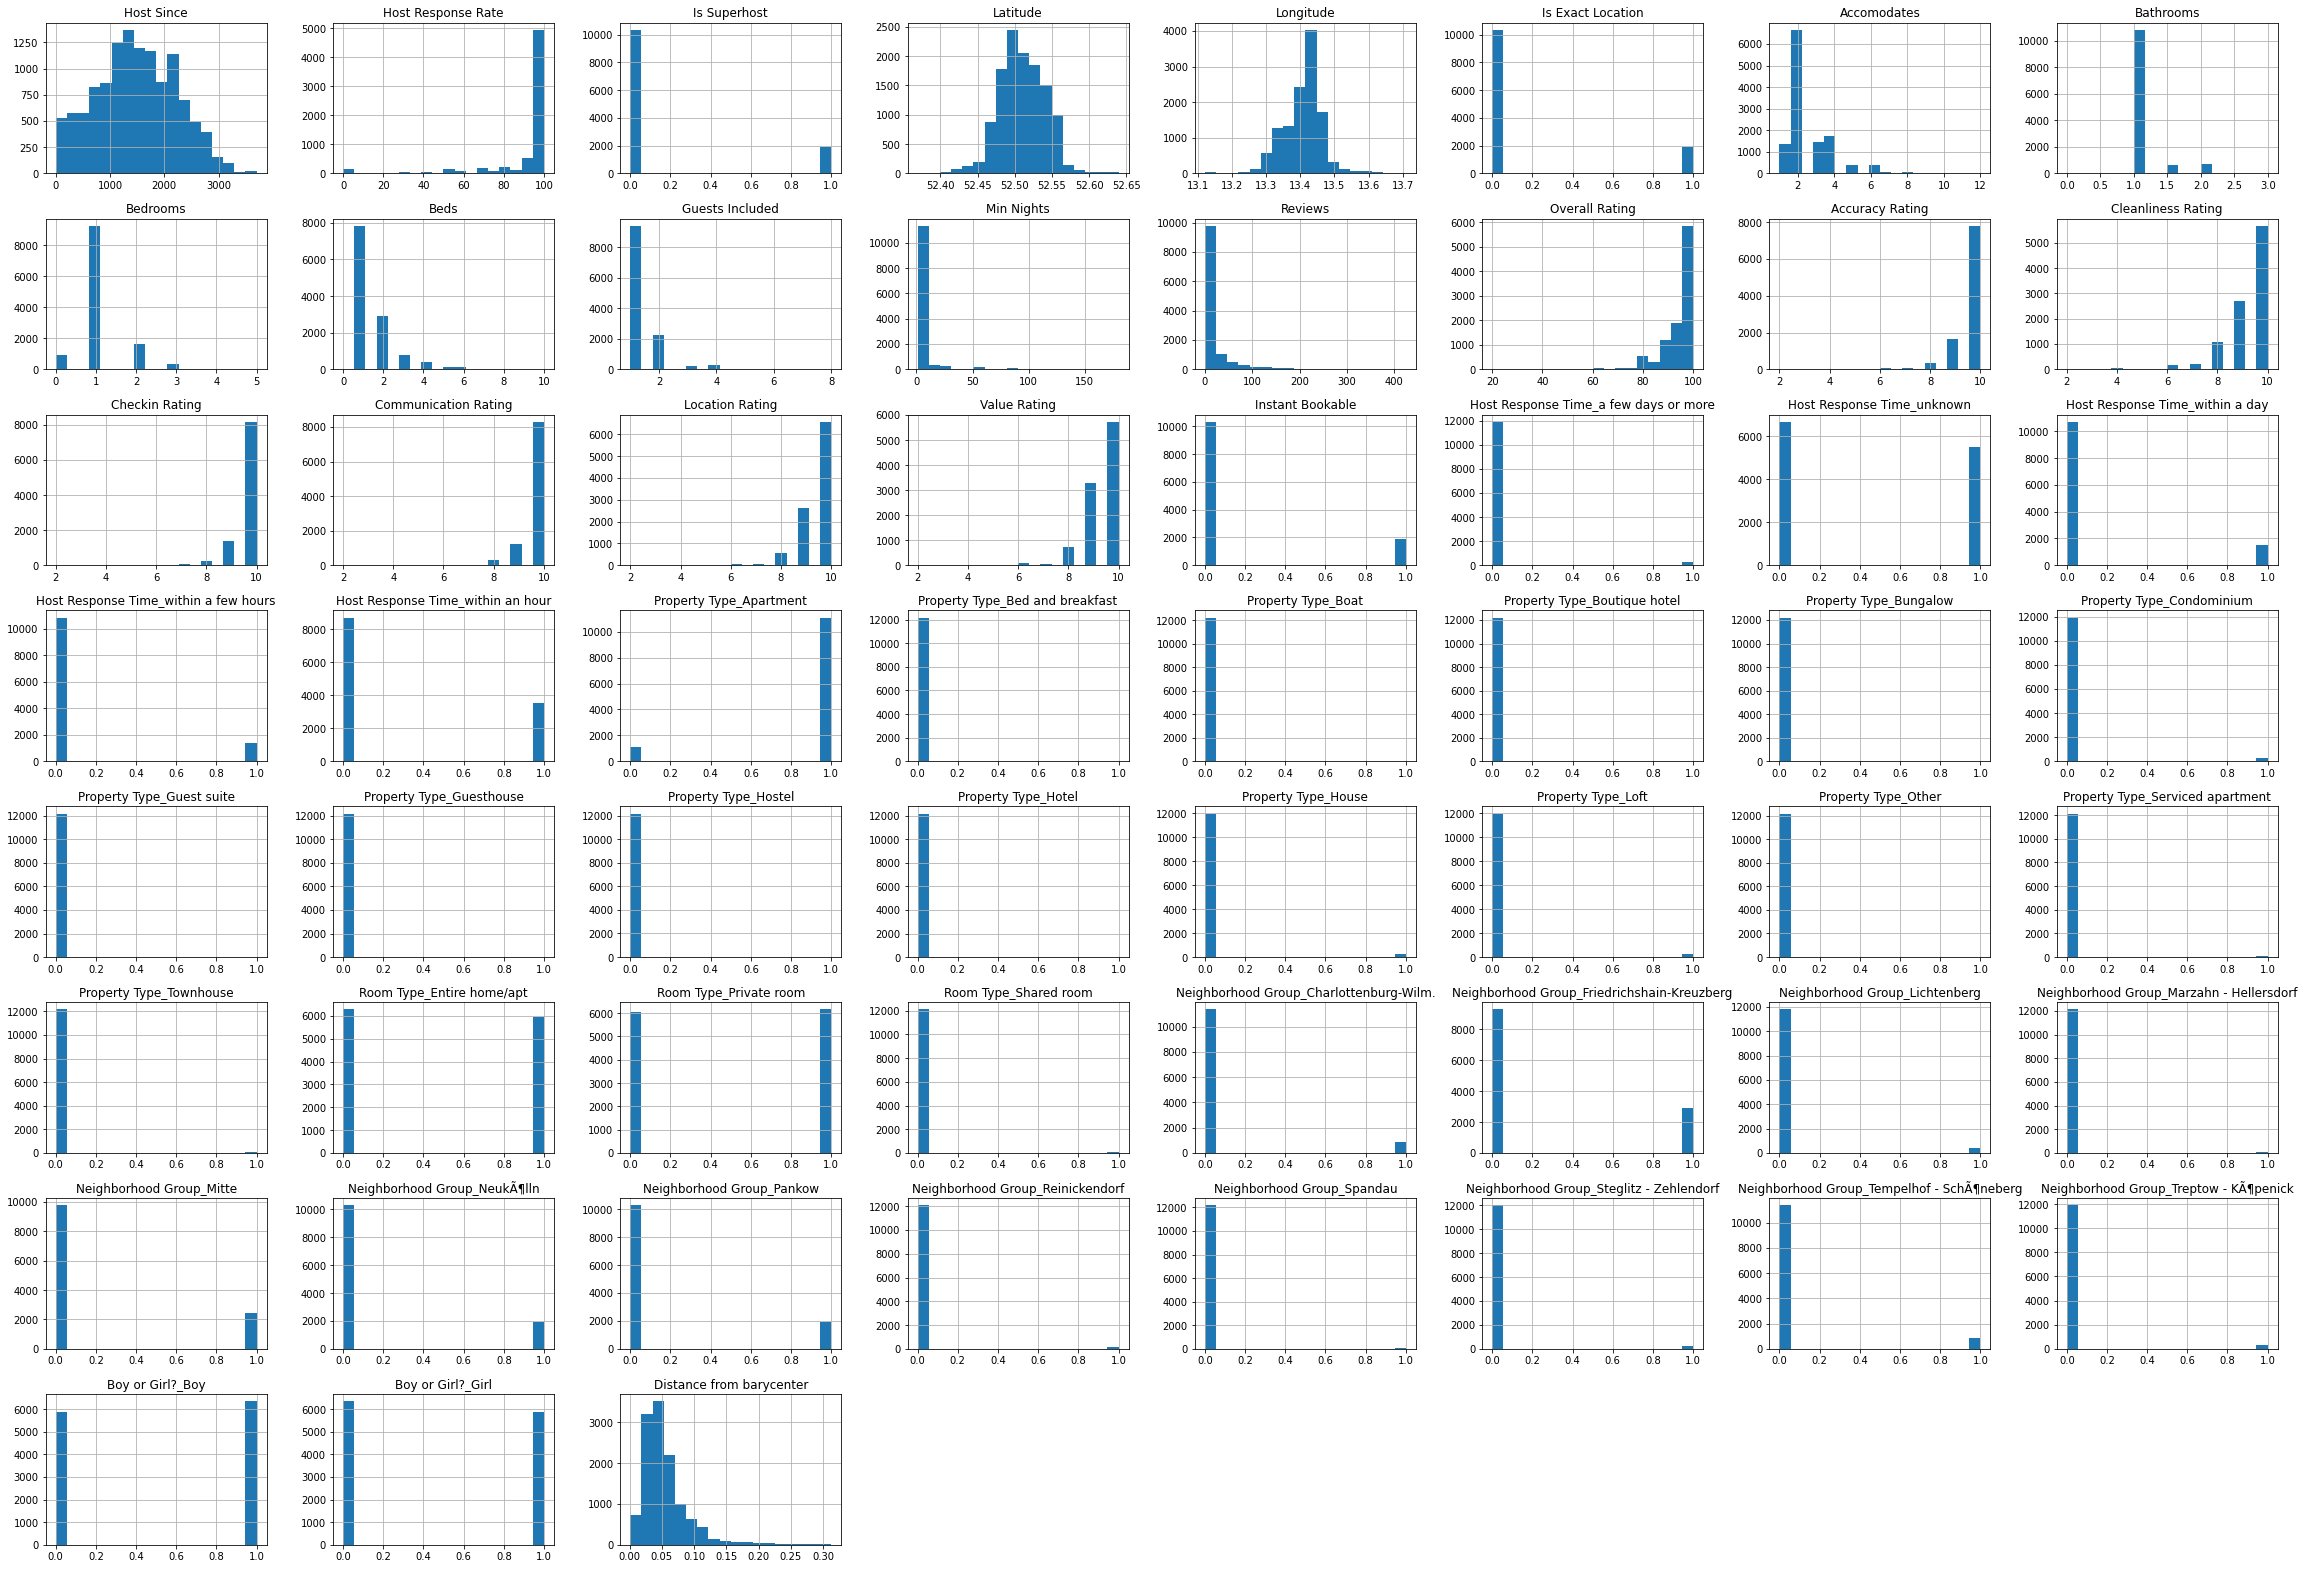

In [18]:
X_train.hist(figsize=(40,28), bins=18)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49b3efa850>,
      dtype=object)

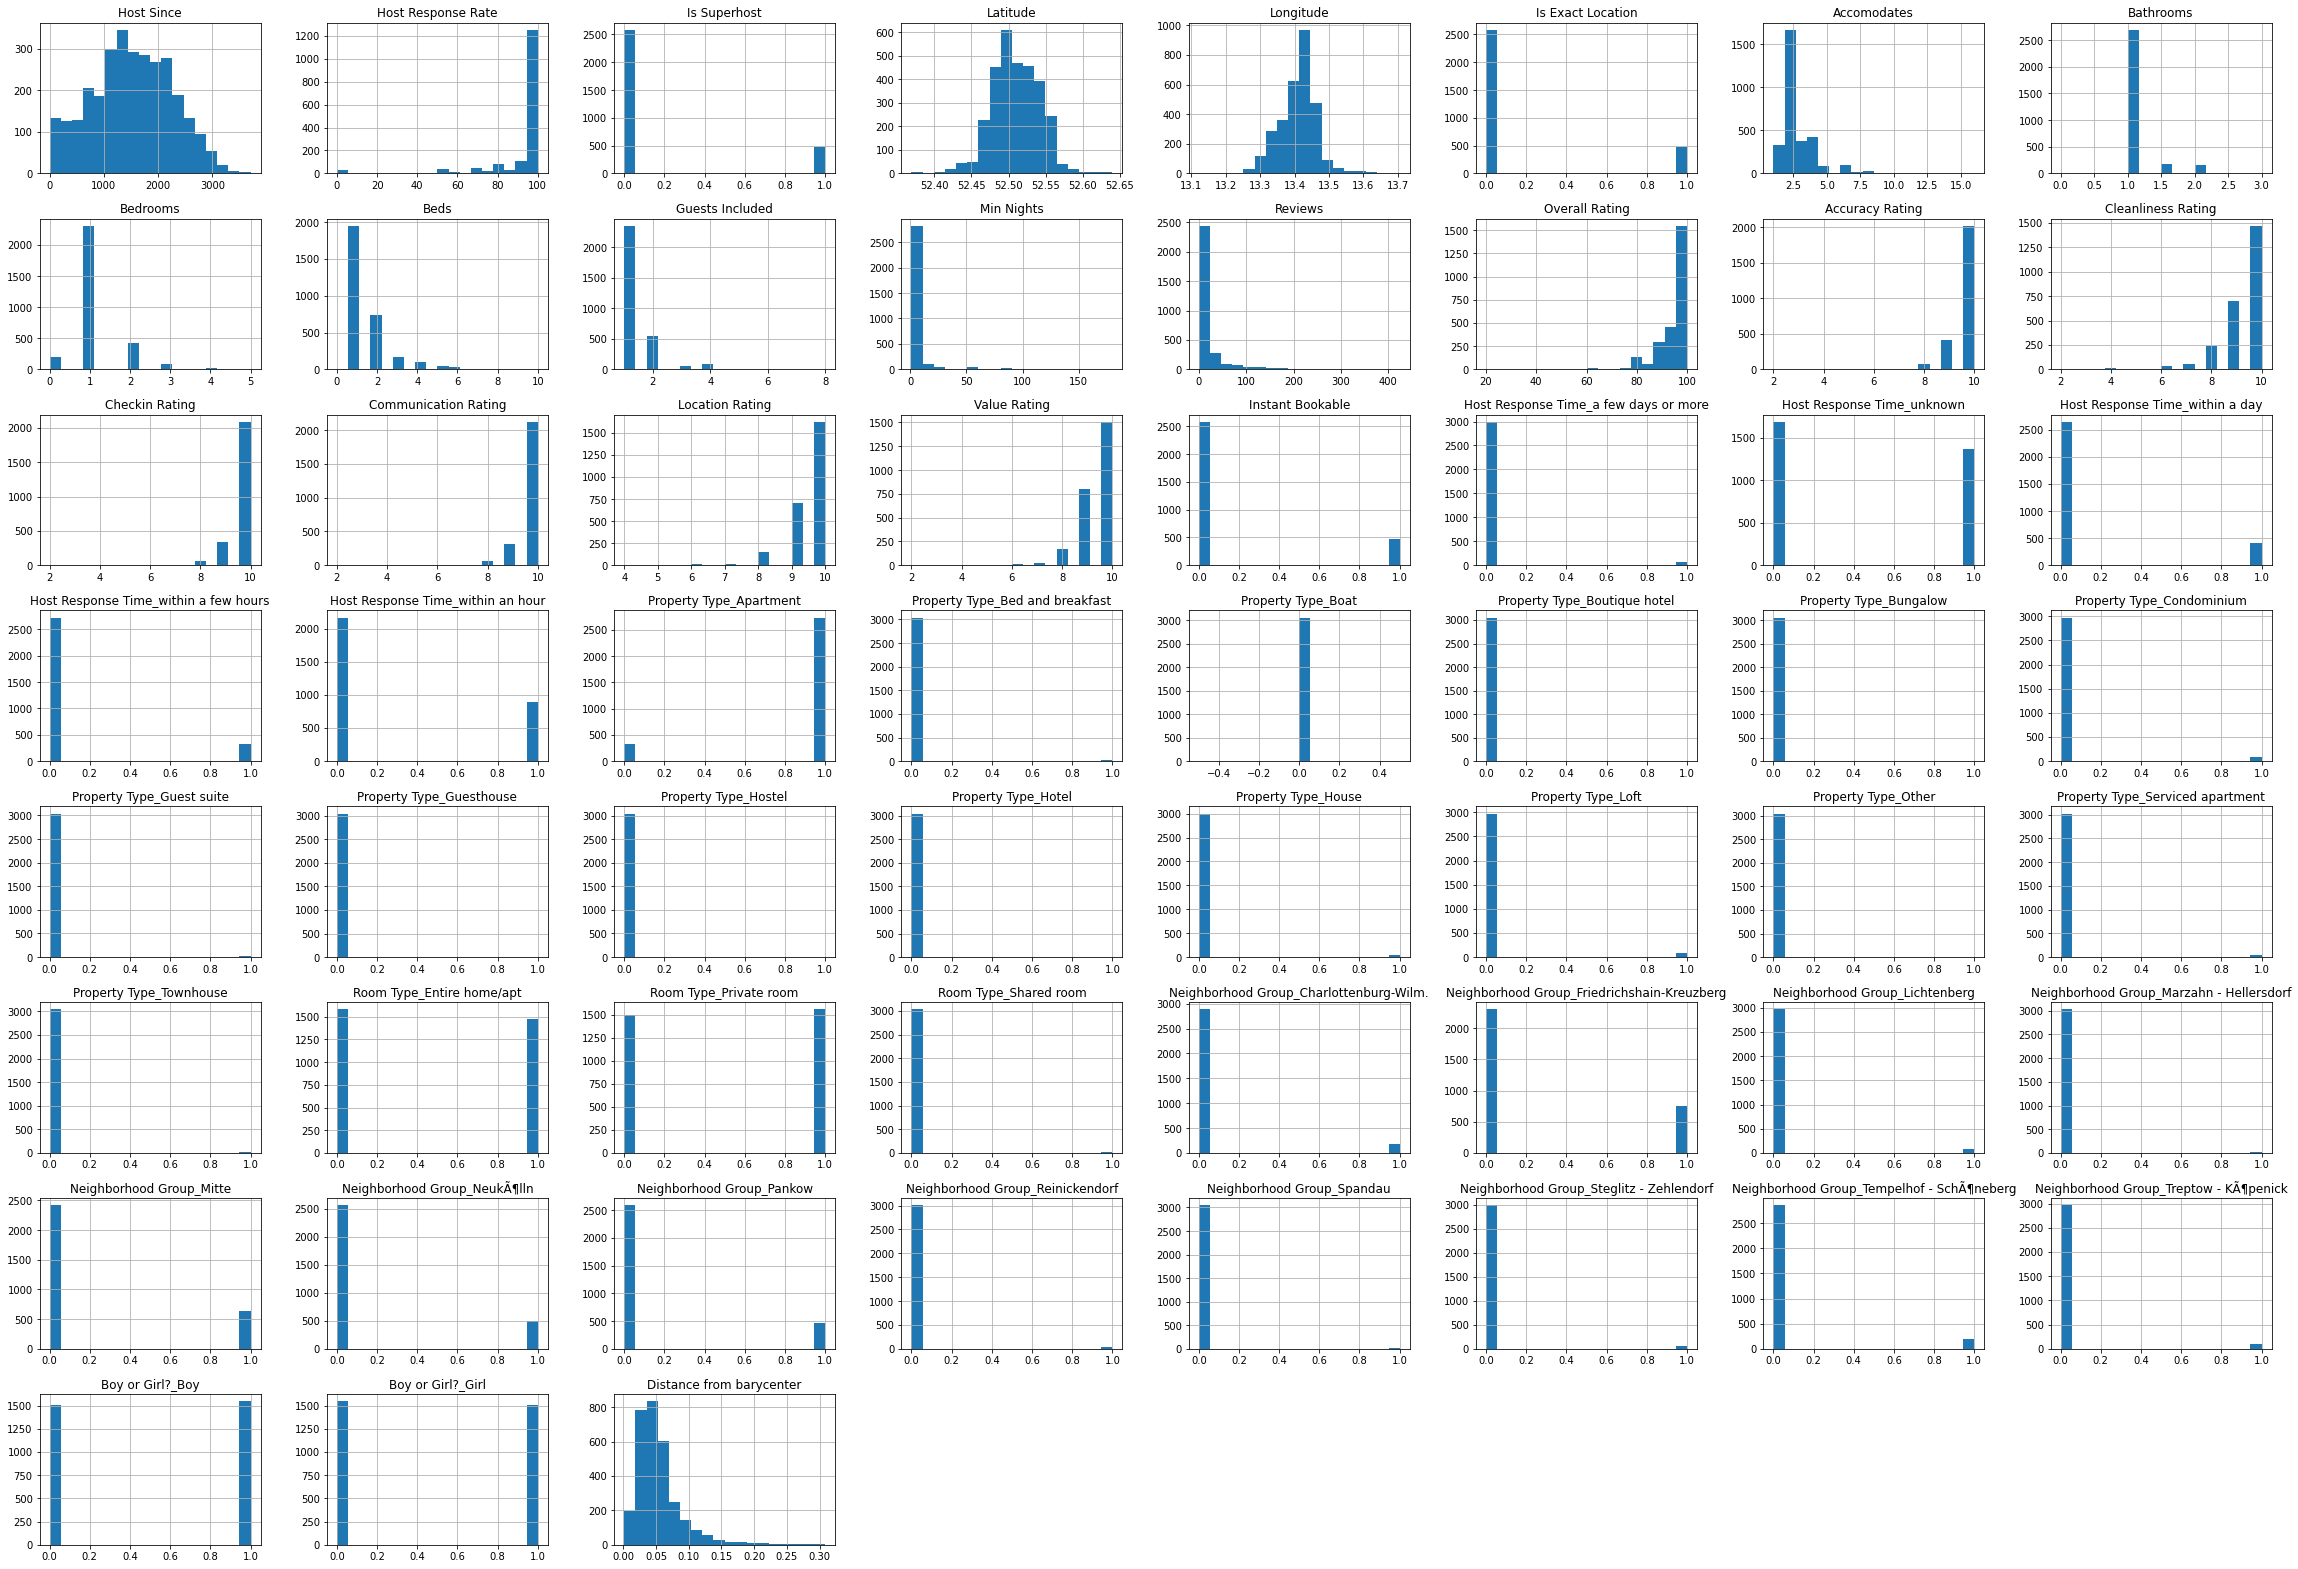

In [19]:
X_test.hist(figsize=(40,28), bins=18)

We can see that the split kept more less the same repartition 

## III/ First rough application of the algorithm as Random Forest Regressor can take in not standarized data 

Here we will do a rough imputation with the mean value and see what we get. We will see if that's the best solution later on 

In [23]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train_imp = imp_mean.transform(X_train)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_test)
X_test_imp = imp_mean.transform(X_test)

## Definition of the model 
model_rf = RandomForestRegressor(n_estimators=200)
## Fit of the model 
model_rf.fit(X_train_imp, y_train)
## Predict on the test 
y_train_pred = model_rf.predict(X_test_imp)

## Metrics 
mse = mean_squared_error(y_train_pred, y_test)
mae = mean_absolute_error(y_train_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_train_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')



Mean Squared Error : 1125.9196371480025
Mean Absolute Error : 20.691365422396856
Root Mean Absolute Error : 33.554726003172824
R2 Score: 0.43140156214453496


We get the values :

- Mean Squared Error : 1125.9196371480025
- Mean Absolute Error : 20.691365422396856
- Root Mean Absolute Error : 33.554726003172824
- R2 Score: 0.43140156214453496

The results are not too bad for a first version of the model.

## IV/ Now let's try to make this algorithme better ! 

###A/ What type of imputation ? 

We will test 2 types of imputations for our missing data, as in our case there is no need of doing anything else than :
- Mean 
- Median 

In [26]:
## Mean 

pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_train_pred, y_test)
mae = mean_absolute_error(y_train_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_train_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error : 1128.6156422314996
Mean Absolute Error : 20.68485428945645
Root Mean Absolute Error : 33.59487523762366
R2 Score: 0.4300400579764313


In [27]:
## Median 
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                    ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_train_pred, y_test)
mae = mean_absolute_error(y_train_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_train_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error : 1124.7219692923215
Mean Absolute Error : 20.6563646037983
Root Mean Absolute Error : 33.5368747693091
R2 Score: 0.43200639400761076


Median imputation seems better with an mse of 1124.72. Let's go with that ! 

### B/ What type of standardization ? 

Random Forest Classifiers are not so much affected by data normalization. Let's see if it is the case for Random Forest Regressors. To do that we will see the results for **not normalized data**, for **min-max normalization** and **Standardization**. 

In [28]:
# Regression
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                    ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Accuracy score without normalization: {mean_squared_error(y_test, y_pred)}')

## Min-max normalization
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators=400))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Accuracy score with min-max normalization: {mean_squared_error(y_test, y_pred)}')
      
## Standardization

pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                    ('scaler', StandardScaler()),
                    ('rf', RandomForestRegressor())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Accuracy score with standardization: {mean_squared_error(y_test, y_pred)}')

Accuracy score without normalization: 1133.723295831287
Accuracy score with min-max normalization: 1131.131694785527
Accuracy score with standardization: 1150.683522167649


The scores we get are : 

- Accuracy score without normalization: 1133.723295831287
- Accuracy score with min-max normalization: 1131.131694785527
- Accuracy score with standardization: 1150.683522167649

The scores are not that different however we can see that min-max normalization does improve the score. So let's go with that for the rest of our algorithms ! 

### B/ Random Search 

For the random search we will do a first test only looking for n_estimators and max_depth 

In [31]:
## Changing X_train 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train)
X_train_imp = imp_median.transform(X_train)

scaler = MinMaxScaler()
scaler.fit(X_train_imp)
X_train_imp = scaler.transform(X_train_imp)

## Random Search : 
rf = RandomForestRegressor()
param = {'n_estimators':[200,300,400,500], 'max_depth':[3,5,10,15,30]}
random_search = RandomizedSearchCV(rf, param, scoring='neg_root_mean_squared_error', n_iter=10, cv=5, n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train_imp, y_train)
results = pd.DataFrame.from_dict(random_search.cv_results_)
random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestRegressor(max_depth=5, n_estimators=300)

In [32]:
print(f'Best parameters are {random_search.best_params_}') 
print(f'Best score is {random_search.best_score_ * -1}')
print(f'Best model is {random_search.best_estimator_}')
print("scores {}".format(random_search.cv_results_['mean_test_score']))

Best parameters are {'n_estimators': 300, 'max_depth': 5}
Best score is 38.898280860697376
Best model is RandomForestRegressor(max_depth=5, n_estimators=300)
scores [-39.5281817  -39.61814294 -39.47217223 -39.52700423 -39.29439204
 -38.89828086 -39.27679984 -39.54011187 -39.47558558 -39.58452575]


Based on this, we will go with n_estimators = 300 and max_depth = 5 
But let's try with more hyperparameter to see if we can get a better result 

In [85]:
## Changing X_train 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train)
X_train_imp = imp_median.transform(X_train)

scaler = MinMaxScaler()
scaler.fit(X_train_imp)
X_train_imp = scaler.transform(X_train_imp)

## Random Search : 
rf = RandomForestRegressor()
param = {'n_estimators':[200,300,400],
          'max_depth':[5,10,20,30],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 3],
          'min_samples_split': [2, 7],
}

random_search = RandomizedSearchCV(rf, param, scoring='neg_root_mean_squared_error', n_iter=10, cv=5, n_jobs=-1, verbose=10, random_state=42)

random_search.fit(X_train_imp, y_train)
results = pd.DataFrame.from_dict(random_search.cv_results_)
random_search.best_estimator_

print(f'Best parameters are {random_search.best_params_}') 
print(f'Best score is {random_search.best_score_ * -1}')
print(f'Best model is {random_search.best_estimator_}')
print("scores {}".format(random_search.cv_results_['mean_test_score']))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters are {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 30}
Best score is 37.90289400973615
Best model is RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=7, n_estimators=300)
scores [-38.56517514 -39.27374459 -39.50568298 -37.90289401 -38.46517023
 -38.54938088 -37.9336994  -38.10573949 -38.95014913 -38.83081882]


In [90]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error : 1009.8805704247005
Mean Absolute Error : 19.66339453942878
Root Mean Absolute Error : 31.778618132711507
R2 Score: 0.49000222056826104


We clearly get a better result ! 

### D/ Feature selection 

Random Forest don't necessarly need to do a feature selection. As it is itself a method to do feature selection because each tree will consider a small amount of features, thus Random Forest is not really concerned by the curse of dimentionality. But we will proceed with a forward feature selection just to see and so that we can compare it with what the random forest features selector  will tell us in terms of number of important features. 

We will do this selection on only n_estimators = 10, I know it is not great but it is mainly to get a general idea, as I tried to run it for n_estimators = 100 and it took hours without finishing, so we will do the test with only n_estimators=10 

In [39]:
import time 
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns)

## X_test 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_test)
X_test_imp = imp_median.transform(X_test)

scaler = MinMaxScaler()
scaler.fit(X_test_imp)
X_test_imp = scaler.transform(X_test_imp)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns)


def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train_imp.columns if d not in features]
    tic = time.time()
    results = []
    
    for d in remaining_features:
        model = RandomForestRegressor(n_estimators=10)
        model = model.fit(X_train_imp[features+[d]], y_train)
        RSS = ((model.predict(X_test_imp[features+[d]]) - y_test) ** 2).sum()
        results.append({"model":model, "features":features+[d], "RSS":RSS})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    toc = time.time() 

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [40]:
models_fwd = pd.DataFrame(columns=["RSS", "features", "model"])

tic = time.time()
features = []

for i in range(1,len(X_train_imp.columns)+1):  
    model = forward(features)
    models_fwd.loc[i] = model
    features = model["features"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 59 models on 1 features in 1.9837002754211426 seconds.
['Bedrooms']
Processed 58 models on 2 features in 2.182588815689087 seconds.
['Bedrooms', 'Room Type_Entire home/apt']
Processed 57 models on 3 features in 2.284080982208252 seconds.
['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms']
Processed 56 models on 4 features in 2.6947567462921143 seconds.
['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown']
Processed 55 models on 5 features in 2.9498209953308105 seconds.
['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel']
Processed 54 models on 6 features in 3.046644449234009 seconds.
['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Guests Included']
Processed 53 models on 7 features in 3.5018866062164307 seconds.
['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Guests In

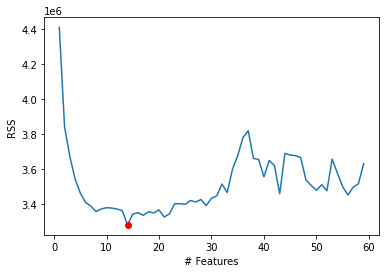

In [41]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
plt.plot(models_fwd["RSS"].idxmin(), models_fwd["RSS"].min(), "or")

In [42]:
# Obtaining features of the best model according to the FSS
idx_min = models_fwd["RSS"].idxmin()
best_model_fwd = models_fwd["model"][idx_min]

best_rss_fwd = models_fwd["RSS"].min()

print(f'The best model according to the FSS is: {best_model_fwd} ({len(best_model_fwd)} features).')
print('The corresponding RSS is:', best_rss_fwd)

The best model according to the FSS is: RandomForestRegressor(n_estimators=10) (10 features).
The corresponding RSS is: 3281388.3104712944


In [43]:
idx_min = models_fwd["RSS"].idxmin()
best_features = models_fwd["features"][idx_min]
print(best_features)

['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Guests Included', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Is Superhost', 'Property Type_Other', 'Property Type_Hostel', 'Room Type_Private room', 'Instant Bookable', 'Property Type_House', 'Neighborhood Group_Treptow - KÃ¶penick']


Based on the graph, the best model is obtained for around 15 features. 

Now let's see what features does the RF consider as important :


In [91]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [92]:
importances = list(pipe['rf'].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Accomodates          Importance: 0.12
Variable: Bedrooms             Importance: 0.11
Variable: Room Type_Entire home/apt Importance: 0.09
Variable: Room Type_Private room Importance: 0.07
Variable: Bathrooms            Importance: 0.06
Variable: Beds                 Importance: 0.06
Variable: Distance from barycenter Importance: 0.06
Variable: Host Since           Importance: 0.05
Variable: Latitude             Importance: 0.05
Variable: Guests Included      Importance: 0.05
Variable: Longitude            Importance: 0.04
Variable: Reviews              Importance: 0.04
Variable: Min Nights           Importance: 0.02
Variable: Overall Rating       Importance: 0.02
Variable: Property Type_Loft   Importance: 0.02
Variable: Host Response Rate   Importance: 0.01
Variable: Cleanliness Rating   Importance: 0.01
Variable: Location Rating      Importance: 0.01
Variable: Value Rating         Importance: 0.01
Variable: Host Response Time_unknown Importance: 0.01
Variable: Host Response

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Here we see a very intersting thing, that the forward feature selection even with n_estimators = 10 noticed that only around 15 features were important, and with Random Forest we can see that only 17 features have an impact. 

### V/ Rerunning the best version of the algorithm

Therefore, the best algortihm has : 
 - Median imputation 
 - min -max normalization 
 - n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30
 - We will compare the results for the features 

First with all the features : 

In [93]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error : 1004.9052575965535
Mean Absolute Error : 19.66903909080229
Root Mean Absolute Error : 31.700240655183574
R2 Score: 0.4925147934096873


With all the features we get a good result : 
- Mean Squared Error : 1004.9052575965535
- Mean Absolute Error : 19.66903909080229
- Root Mean Absolute Error : 31.700240655183574
- R2 Score: 0.4925147934096873

In [94]:
list_features=[]
for i in range(len(feature_importances)):
    if feature_importances[i][1]>0:
        list_features.append(feature_importances[i][0]) 
print(list_features)

['Accomodates', 'Bedrooms', 'Room Type_Entire home/apt', 'Room Type_Private room', 'Bathrooms', 'Beds', 'Distance from barycenter', 'Host Since', 'Latitude', 'Guests Included', 'Longitude', 'Reviews', 'Min Nights', 'Overall Rating', 'Property Type_Loft', 'Host Response Rate', 'Cleanliness Rating', 'Location Rating', 'Value Rating', 'Host Response Time_unknown', 'Host Response Time_within an hour', 'Property Type_Apartment', 'Property Type_Hotel', 'Property Type_Serviced apartment', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Neighborhood Group_Mitte', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl']


In [95]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train[list_features], y_train)
y_pred = pipe.predict(X_test[list_features])

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error : 1018.0858809358963
Mean Absolute Error : 19.72263706193566
Root Mean Absolute Error : 31.907458077006012
R2 Score: 0.48585847301750074


Therefore with our optimized algorithm having lower feature we get the results :
 
- Mean Squared Error : 1018.0858809358963
- Mean Absolute Error : 19.72263706193566
- Root Mean Absolute Error : 31.907458077006012
- R2 Score: 0.48585847301750074

Now lets try with the features returned by the forward selection 

In [65]:
from csv import list_dialects
list_features_FS= best_features
print(list_features_FS)
print(len(list_features_FS))

['Bedrooms', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Guests Included', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Is Superhost', 'Property Type_Other', 'Property Type_Hostel', 'Room Type_Private room', 'Instant Bookable', 'Property Type_House', 'Neighborhood Group_Treptow - KÃ¶penick']
14


In [96]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train[list_features_FS], y_train)
y_pred = pipe.predict(X_test[list_features_FS])

## Metrics 
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Printing the metrics 
print(f'Mean Squared Error : {mse}')
print(f'Mean Absolute Error : {mae}')
print(f'Root Mean Absolute Error : {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error : 1060.3730527101472
Mean Absolute Error : 20.473783199103092
Root Mean Absolute Error : 32.563369799671335
R2 Score: 0.4645031124581358


By trying with the best features selection, we get a worse RMSE. 
The Best results are when we keep all the features ! ( Proving that Random Forest is not so much touched by the curse of dimension ) 

## VI/ Analysis of the outcome 

Now that we have optimized our algorithm as much as possible, we will analyze the predictions ( basicly plot pretty pictures ) 

In [97]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 30))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

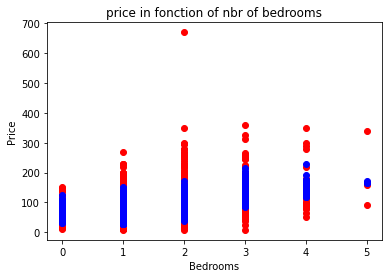

In [98]:
plt.scatter(X_test['Bedrooms'],y_test, color='red') #plotting real points
plt.scatter(X_test['Bedrooms'], y_pred ,color='blue') #plotting f

plt.title("price in fonction of nbr of bedrooms")
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

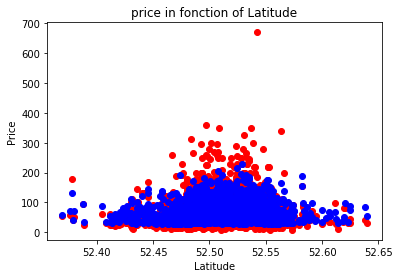

In [99]:
plt.scatter(X_test['Latitude'],y_test, color='red') #plotting real points
plt.scatter(X_test['Latitude'], y_pred,color='blue') #plotting f


plt.title("price in fonction of Latitude")
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.show()

We see here that RF is good at getting the general tendancy, and does not overfit as it doesn't get the outliers 

In [74]:
# Visualisation of a part of the random forest
from sklearn.tree import export_graphviz
import pydot

tree = pipe['rf'].estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_train.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png'); 

Here we have the visualisation of one of the tree of our forest 
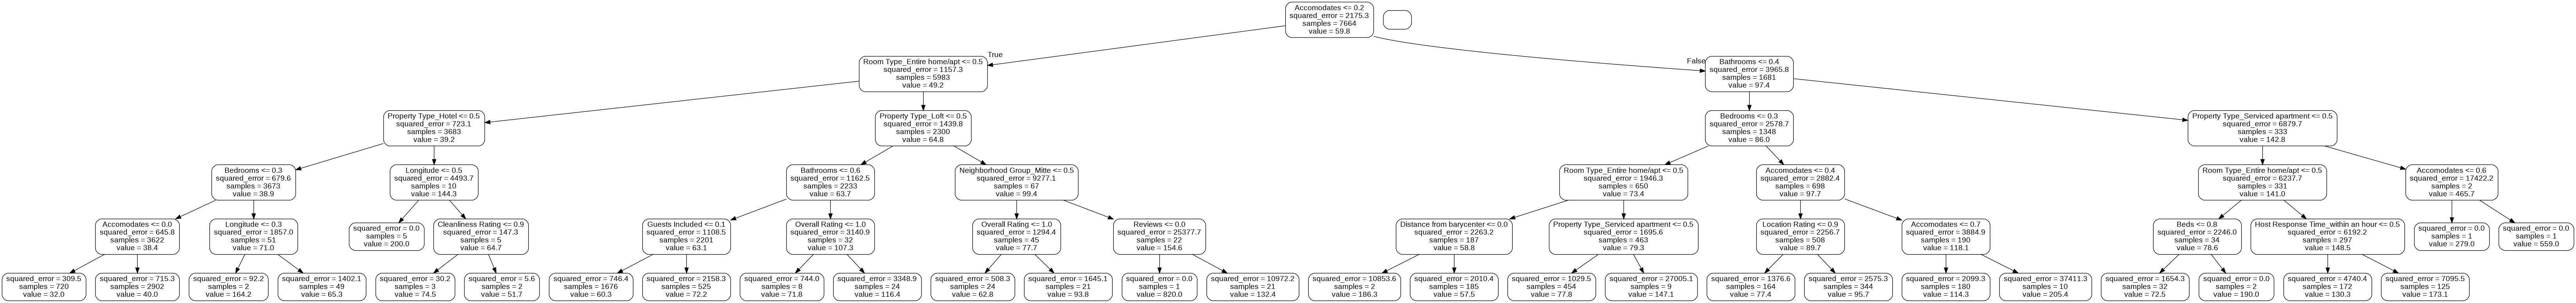


### VI/ SHAPLEY VALUES 

In [77]:
!pip install shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 26.5 MB/s 


Shapley values for random forest are very sensible to max_depth. If max_depth is too high it will run for hours, so we will do the shapley values for max_depth = 5, just to get a general idea of how to explain our features 

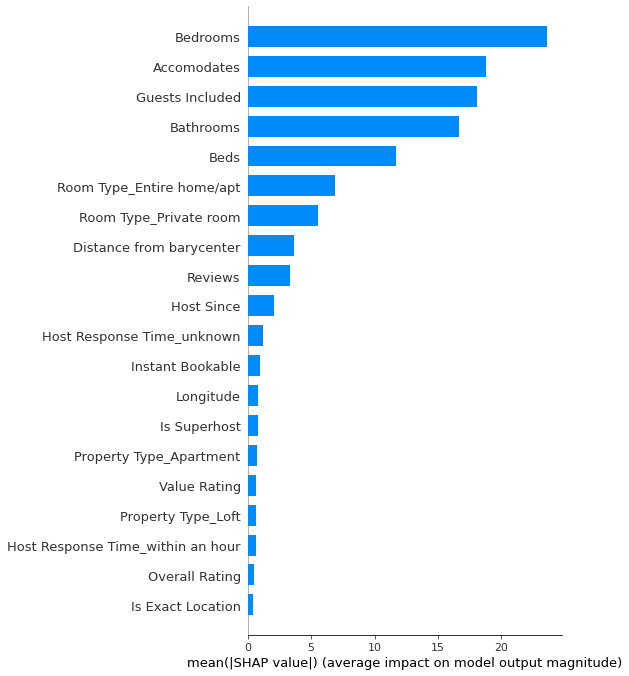

In [4]:
import shap
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler',MinMaxScaler()),
                 ('rf', RandomForestRegressor(n_estimators= 300, min_samples_split= 7, min_samples_leaf= 3, max_features='sqrt', max_depth= 5))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

explainer = shap.TreeExplainer( pipe['rf'] )
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [5]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

With the Shapley values we can go one step further and really understand what impacts our predictions and how. Here for instance we see that the more a listing accomodates people the more the price will be higher, however the number of bedrooms is important and if it is low the price gets lower too. 
( People want a listing that can accomodate them if they are a large groupe but without having to all sleep in the same room I suppose )  
